# Planaria Velocyto Analysis
This is an analysis with the velocyto(.py) package developed by the [Linnarsson lab](http://linnarssonlab.org/) and [Kharchenko Lab](http://pklab.med.harvard.edu/).
<br>
BioRxiv reference https://www.biorxiv.org/content/early/2017/10/19/206052
<br>
This notebook is based on https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/DentateGyrus.ipynb

### Files needed:
1. all_sgete_4GU75.loom
2. color_dict2.txt
3. reg_Seurat_annot.csv
4. tsneCoordinates.csv

In [1]:
import sys
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import loompy
import velocyto as vcy
import pandas as pd

from IPython.core.display import display, HTML
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

/data/murphy/home/amisios/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Importing loom file and annotation (from Seurat analysis)

In [2]:
dirr="/data/murphy/home/amisios/Projects/Planaria/permissive_loomfiles/"
vlm = vcy.VelocytoLoom(dirr+"all_sgete_4GU75.loom")
ds = loompy.connect(dirr+"all_sgete_4GU75.loom")

2018-02-08 20:12:43,615 - DEBUG - The file did not specify the _Valid column attribute


In [3]:
color_dict = {}
with open("/data/murphy/home/amisios/Projects/Planaria/color_dict2.txt") as f:
    for line in f:
       (key, val) = line.strip("\n").split("\t")
       color_dict[key] = val
        
### Get the velocyto cell barcodes
velo_list = [x[16:29] for x in list(vlm.ca["CellID"])]

### Get seurat cells and annotation
base_dir = "/data/murphy/home/amisios/Projects/Planaria/"
file = "reg_Seurat_annot.csv"
annotation = pd.read_csv(base_dir+file, delimiter=',', index_col=0)
tsneCoord = pd.read_csv(base_dir+"tsneCoordinates.csv", delimiter=',', index_col=0)
annotation = pd.merge(annotation, tsneCoord, left_index=True, right_index=True)
annotation = annotation.set_index('newCBC')
annotation = annotation.loc[velo_list]

# add cluster, color and time as annotation from Seurat object to velocyto object
vlm.set_clusters(cluster_labels=list(np.array(annotation["final_Id"])), cluster_colors_dict=color_dict)
vlm.ca["Clusters"] = vlm.cluster_ix
vlm.ca["time"] = np.array(annotation["time"])
vlm.ca["final_Id"] = np.array(annotation["final_Id"])
vlm.ts=annotation.loc[:,["tSNE_1","tSNE_2"]].values

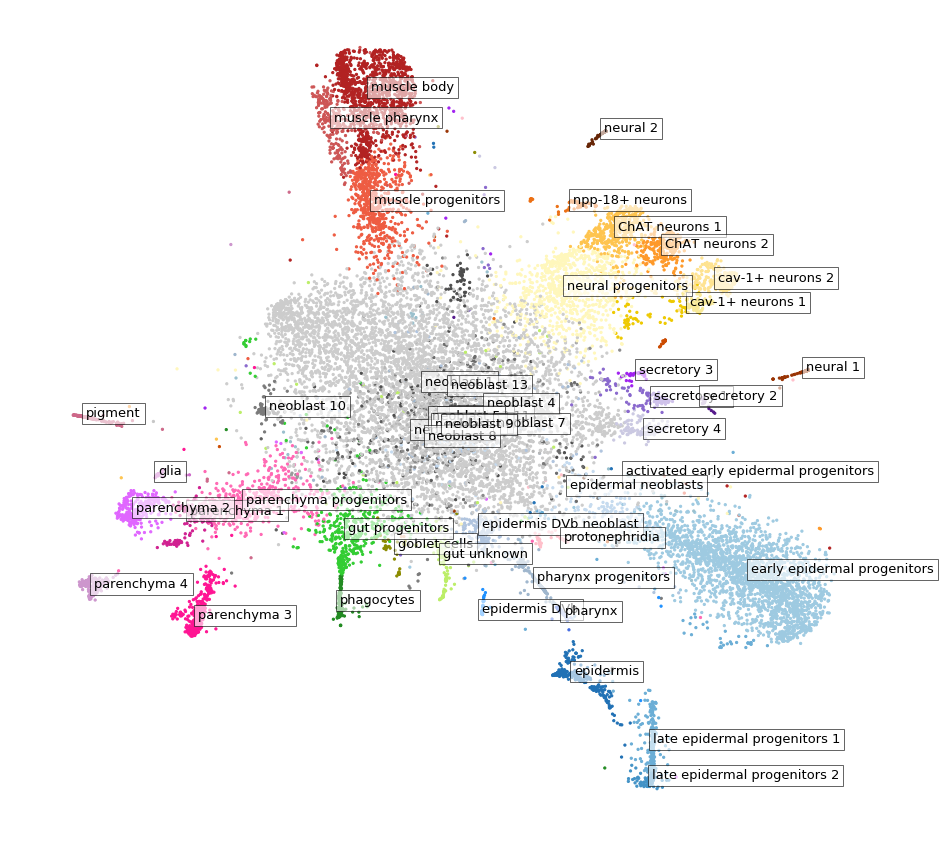

In [4]:
# Plot TSNE
plt.figure(figsize=(15,15))
vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=5)
for i in range(max(vlm.ca["Clusters"])):
    ts_m = np.median(vlm.ts[vlm.ca["Clusters"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(vlm.cluster_labels[vlm.ca["Clusters"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

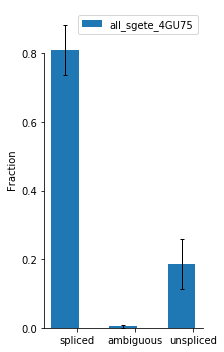

In [5]:
vlm.plot_fractions()

### Filtering genes

In [6]:
vlm.normalize("S", size=True,  log=False)
vlm.normalize("U", size=True,  log=False)

2018-02-08 20:13:20,868 - DEBUG - svr_gamma set to 0.011861458168590858
4003
2018-02-08 20:13:25,776 - DEBUG - Filtering by cv vs mean


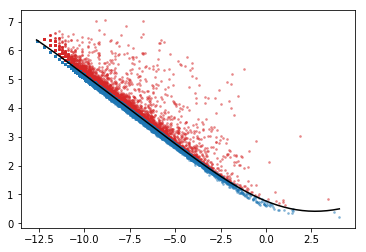

In [7]:
vlm.score_cv_vs_mean(4000, plot=True, max_expr_avg=35)
print(sum(vlm.cv_mean_selected))
vlm.filter_genes(by_cv_vs_mean=True)

In [8]:
vlm.score_detection_levels(min_expr_counts=3, min_cells_express=3, min_expr_counts_U=3, min_cells_express_U=3)
vlm.filter_genes(by_detection_levels=True)
print("Number of genes to be used:",vlm.S.shape[0])

2018-02-08 20:13:26,822 - DEBUG - Filtering by detection level
Number of genes to be used: 2795


### Normalization, Dimension Reduction, Imputation

In [9]:
vlm.normalize_by_total()

number of PCs to be used: 75


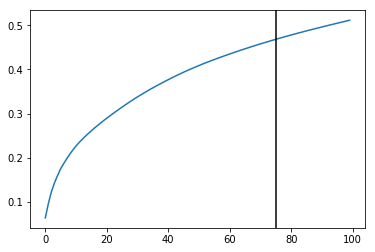

In [10]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print("number of PCs to be used:",n_comps)

In [11]:
k = 200
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

2018-02-08 20:14:10,605 - DEBUG - First search the 1600 nearest neighbours for 19141
2018-02-08 20:14:42,062 - DEBUG - Using the initialization network to find a 200-NN graph with maximum connectivity of 800
2018-02-08 20:14:42,665 - DEBUG - Returning sparse matrix


### Fitting gene steady states, Calculating velocity, transition probability

In [12]:
vlm.normalize_median()
vlm.fit_gammas(limit_gamma=True)

In [13]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1)

In [14]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt",n_neighbors=5000, knn_random=True, sampled_fraction=1)

2018-02-08 20:16:52,415 - DEBUG - Calculate KNN in the embedding space
2018-02-08 20:18:05,901 - DEBUG - Correlation Calculation 'knn_random'
2018-02-08 20:26:17,049 - DEBUG - Done Correlation Calculation


### Plot on tSNE embedding with individual arrows

In [15]:
vlm.calculate_embedding_shift(sigma_corr = 0.02)

2018-02-08 20:26:17,159 - DEBUG - Calculate transition probability


(-20.407147377236875,
 18.51085526493098,
 -22.975752239895336,
 23.008746517788744)

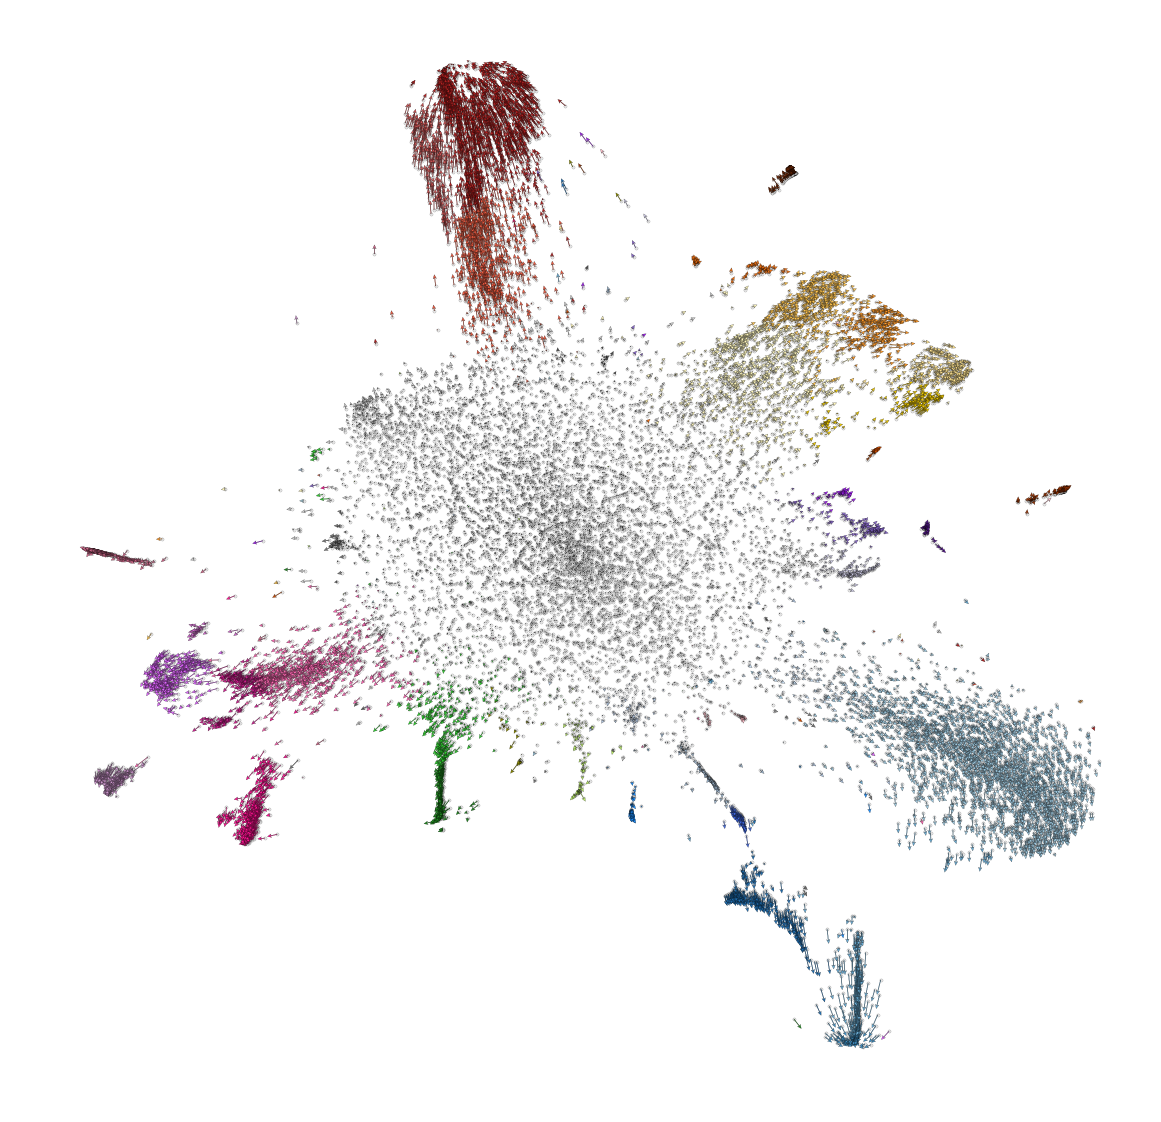

In [16]:
fig = plt.figure(None,(20,20))
quiver_scale = 110

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3)

quiver_kwargs=dict(headaxislength=6, headlength=8, headwidth=7,linewidths=0.2, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")

### Plot on tSNE embedding with vector field

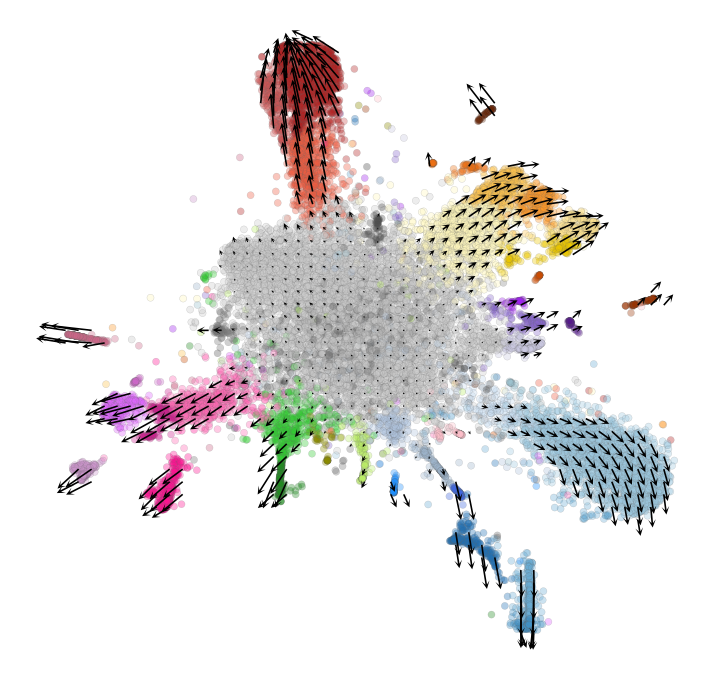

In [17]:
vlm.calculate_grid_arrows(smooth=0.5, steps=(50, 50), n_neighbors=300)
plt.figure(None,(12,12))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":50, "rasterized":True}, min_mass=15, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.5)

### Grid for Markov Process

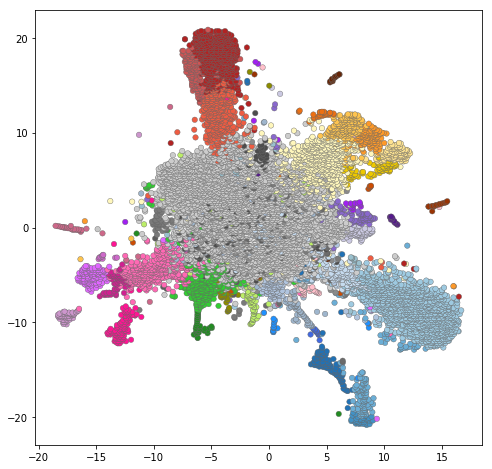

In [18]:
steps = 200, 200  ### 150 , 150
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 1)

diag_step_dist = np.sqrt((meshes_tuple[0][0,0] - meshes_tuple[0][0,1])**2 + (meshes_tuple[1][0,0] - meshes_tuple[1][1,0])**2)
min_dist = diag_step_dist / 2
ixs = ixs[dist < min_dist]
gridpoints_coordinates = gridpoints_coordinates[dist.flat[:]<min_dist,:]
dist = dist[dist < min_dist]

ixs = np.unique(ixs)

plt.figure(None,(8,8))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=vlm.colorandum[ixs], alpha=1, s=30, lw=0.4,
                edgecolor="0.4")

(-20.28596221327129,
 18.450463604181195,
 -22.90698858878898,
 22.939982866682385)

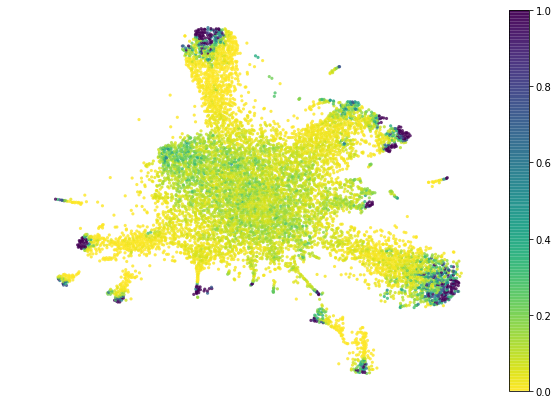

In [19]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='forward', cells_ixs=ixs)
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=2500)

diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)
plt.figure(None,(10,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.8, s=10, lw=0.,
                edgecolor="", cmap="viridis_r")

cm = plt.cm.get_cmap('viridis_r')
plt.colorbar()
plt.axis("off")

(-20.28596221327129,
 18.450463604181195,
 -22.90698858878898,
 22.939982866682385)

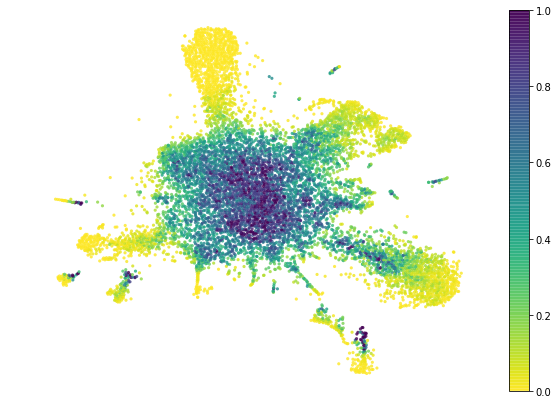

In [20]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='backwards', cells_ixs=ixs)
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=3000)

diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 98)
diffused_n = np.clip(diffused_n, 0, 1)
plt.figure(None,(10,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.8, s=10, lw=0.,
                edgecolor="", cmap="viridis_r")
cm = plt.cm.get_cmap('viridis_r')
plt.colorbar()
plt.axis("off")